## Chapter 13: Multi-layer Perceptrons 

# EXAMPLES

In [4]:
# This code cell will not be shown in the HTML version of this notebook
# imports from custom library
import sys
sys.path.append('../../')
import matplotlib.pyplot as plt
from mlrefined_libraries import basics_library as baslib
from mlrefined_libraries import calculus_library as callib
from mlrefined_libraries import math_optimization_library as optlib
from mlrefined_libraries import linear_algebra_library as linlib
from mlrefined_libraries import superlearn_library as superlearn
import autograd.numpy as np
import time

# import automatic differentiator
from autograd import grad 

# this is needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook

from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

#### <span style="color:#a50e3e;">Example 4. </span>  Normalized gradient descent for MLPs

In this Example we compare $100$ iterations of normalized and unnormalized gradient descent on a real two-class classification dataset collected for the task of face detection, consisting of $P=10,000$ face and non-face images.

In [5]:
# This code cell will not be shown in the HTML version of this notebook
# import custom library
from mlrefined_libraries.deeplearning_library_v1 import superlearn_setup

# define path to datasets
datapath = '../../mlrefined_datasets/'

csvname = datapath + 'convnet_datasets/feat_face_data.csv'
data = np.loadtxt(csvname, delimiter = ',')
x = data[:,:-1].T
y = data[:,-1:].T

Once the data is loaded, we move on to initiate a supervised learning instance using our deep learning library, create a four-layer neural network basis consisting of $10$ units in each layer, and choose an activation function (here, ReLU), data normalization scheme (here, standard normalization) as well as the cost function (here, softmax).  

In [6]:
# initiate an instance
demo = superlearn_setup.Setup(x,y)

# choose a neural network architecture
demo.choose_features(name='multilayer_perceptron', layer_sizes=[784,10,10,10,10,1], activation='relu')

# choose a data normalization scheme
demo.choose_normalizer(name = 'standard')

# choose a cost function
demo.choose_cost(name = 'softmax')

We now run both normalized and unnormalized gradient descent for $100$ iterations, using the same initialization and steplength parameter.    

<IPython.core.display.Javascript object>


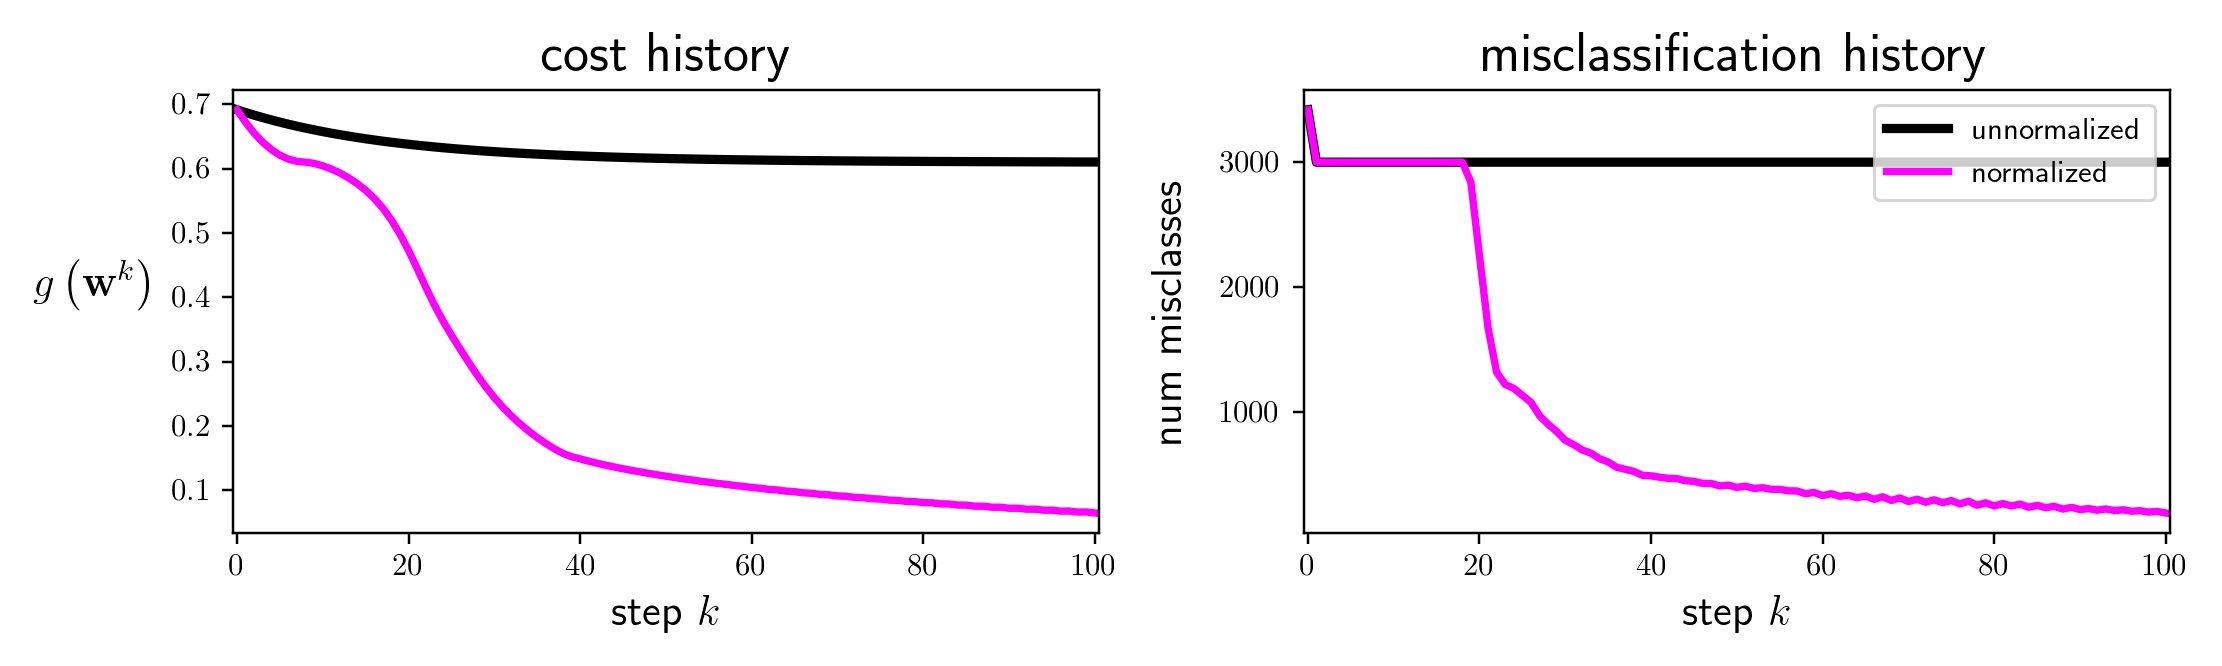

In [23]:
# run unnormalized gradient descent
demo.fit(max_its = 100, alpha_choice = 10**(-1), version='unnormalized')

# run normalized gradient descent
demo.fit(max_its = 100, alpha_choice = 10**(-1), version='normalized')

# plot the results
demo.show_histories(start = 0, labels=['unnormalized','normalized'])

#### <span style="color:#a50e3e;">Example 1. </span>  Batch vs. mini-batch gradient descent on a 10K face detection dataset

In [ ]:
def minibatch_gradient_descent(g, w, alpha, num_pts, batch_size, max_its, version):    
    # flatten the input function, create gradient based on flat function
    g_flat, unflatten, w = flatten_func(g, w)
    grad = compute_grad(g_flat)

    # record history
    w_hist = []
    w_hist.append(unflatten(w))
    
    # how many mini-batches equal the entire dataset?
    num_batches = int(np.ceil(np.divide(num_pts, batch_size)))
    # over the line
    for k in range(max_its):   
        # loop over each minibatch
        for b in range(num_batches):
            # collect indices of current mini-batch
            batch_inds = np.arange(b*batch_size, min((b+1)*batch_size, num_pts))

            # plug in value into func and derivative
            grad_eval = grad(w, batch_inds)
            grad_eval.shape = np.shape(w)

            ### normalized or unnormalized descent step? ###
            if version == 'normalized':
                grad_norm = np.linalg.norm(grad_eval)
                if grad_norm == 0:
                    grad_norm += 10**-6*np.sign(2*np.random.rand(1) - 1)
                grad_eval /= grad_norm
            
            # take descent step with momentum
            w = w - alpha*grad_eval

        # record weight update
        w_hist.append(unflatten(w))

    return w_hist

In this Example we compare $100$ iterations of batch and mini-batch (batch size =$100$) gradient descent using softmax on a real two-class classification dataset collected for the task of face detection, consisting of $P=10,000$ face and non-face images.

In [3]:
# load data
datapath = '../../mlrefined_datasets/convnet_datasets/feat_face_data.csv'
data = np.loadtxt(datapath,delimiter = ',')
x = data[:,:-1]
y = data[:,-1:]
num_pts = len(y)

When applying mini-batch gradient descent it is common practice to first randomize the order of the data prior to running the algorithm to make sure each mini-batch has data points from both classes.  

In [4]:
# randomize the order of data
perm = np.random.permutation(len(x))
x = x[perm]
x = x.T
y = y[perm]

To use mini-batch gradient descent we need a cost function that, in addition to the vector $\mathbf{w}$, also takes in the designated mini-batch. Be careful, we do not want <code>autograd</code> to differentiate with respect to this variable. Most built-in functions in Python are immune to differentiation by <code>autograd</code>, and so we can use them to represent the mini-batch input variable. Here we use <code>iter</code>, a built in Python function for iteration to form the softmax cost function. 

In [5]:
# compute linear combination of input point
def model(x,w):
    # tack a 1 onto the top of each input point all at once
    o = np.ones((1,np.shape(x)[1]))
    x = np.vstack((o,x))
    
    # compute linear combination and return
    a = np.dot(x.T,w)
    return a

In [6]:
def minibatch_softmax(w, iter):
    # get subset of points
    x_p = x[:, iter]
    y_p = y[iter]
    
    cost = (1/len(y_p))*np.sum(np.log(1 + np.exp(-y_p*model(x_p,w))))
    return cost

We now run batch and mini-batch gradient descent with the same initialization and fixed steplength for $100$ iterations and plot the cost function evaluation as well as number of misclassifications for each iteration.   

<IPython.core.display.Javascript object>


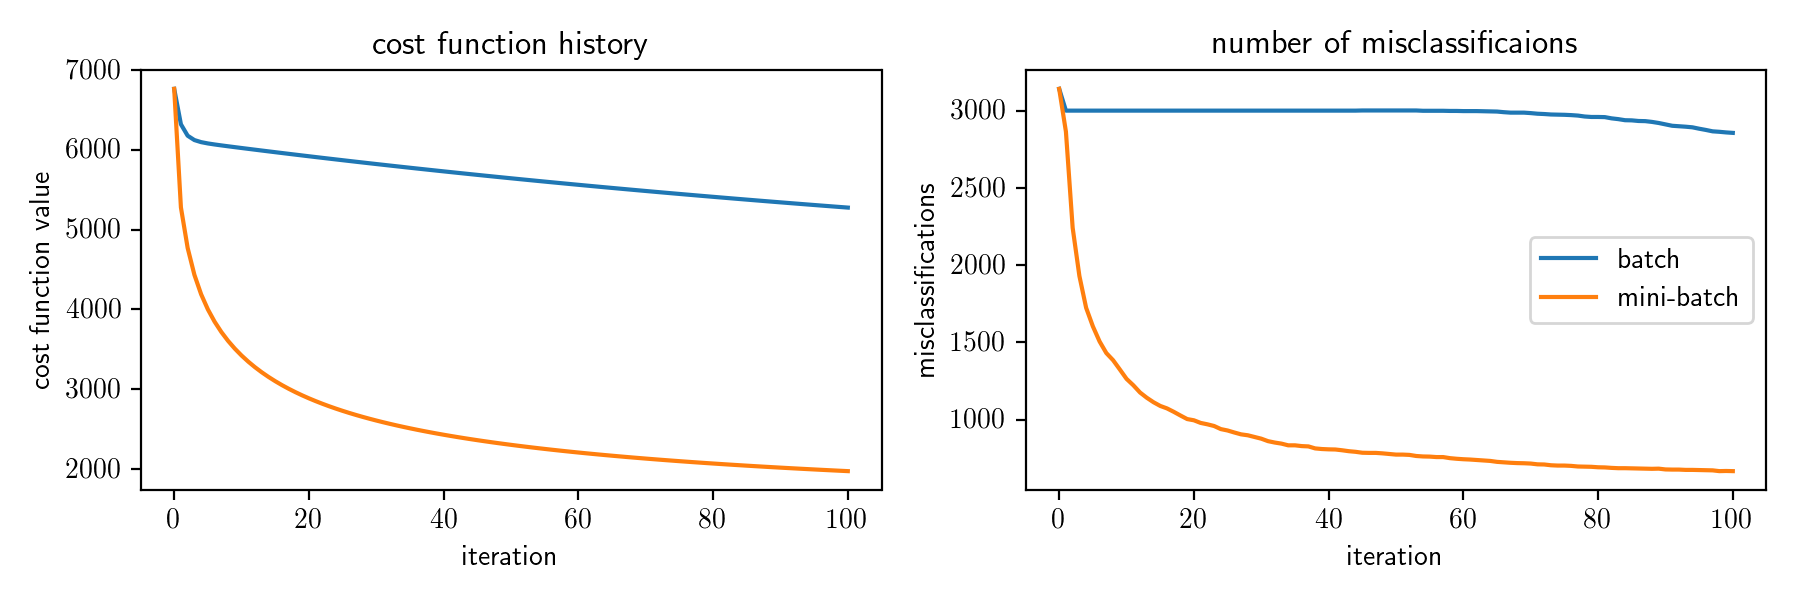

In [7]:
# This code cell will not be shown in the HTML version of this notebook
demo1 = mlplib.plotters.Visualizer()
demo1.compare_classification_histories(minibatch_softmax, x, y,
                                       batch_size=100, alpha=1, max_its=100, version='unnonrmlized')

#### <span style="color:#a50e3e;">Example 2. </span>  Batch vs. mini-batch gradient descent on MNIST

In this Example we compare $40$ iterations of batch and mini-batch (batch size =$500$) gradient descent using multi-class perceptron cost on the MNIST dataset consisting of $P=70,000$ images of hand-written digits 0-9.

In [8]:
# This code cell will not be shown in the HTML version of this notebook
# load data
from sklearn.datasets import fetch_mldata
MNIST = fetch_mldata('MNIST original')
x = MNIST.data.astype('float64')
y = np.reshape(MNIST.target, (-1, 1))
num_pts = len(y)

In [9]:
# This code cell will not be shown in the HTML version of this notebook
# randomize data
perm = np.random.permutation(len(x))
x = x[perm]
x = x.T
y = y[perm]

Once again all we need to do here is slightly adjust the multiclass perceptron cost function to allow for computing the cost for any given subset of data.  

In [10]:
lam = 10**-3  # our regularization paramter 
def minibatch_multiclass_perceptron(w, iter):
    
    # get subset of points
    x_p = x[:, iter]
    y_p = y[iter]
    
    # pre-compute predictions on all points
    all_evals = model(x_p,w)
    
    # compute maximum across data points
    a =  np.max(all_evals, axis = 1)        
    
    # compute cost in compact form using numpy broadcasting
    b = all_evals[np.arange(len(y_p)), y_p.astype(int).flatten()]
    cost = np.sum(a - b)
    
    # add regularizer
    cost = cost + lam*np.linalg.norm(w[1:,:],'fro')**2
    
    # return average
    return cost/float(len(y_p))

We now run batch and mini-batch gradient descent with the same initialization and fixed steplength for $40$ iterations and plot the cost function evaluation as well as number of misclassifications for each iteration. 

<IPython.core.display.Javascript object>


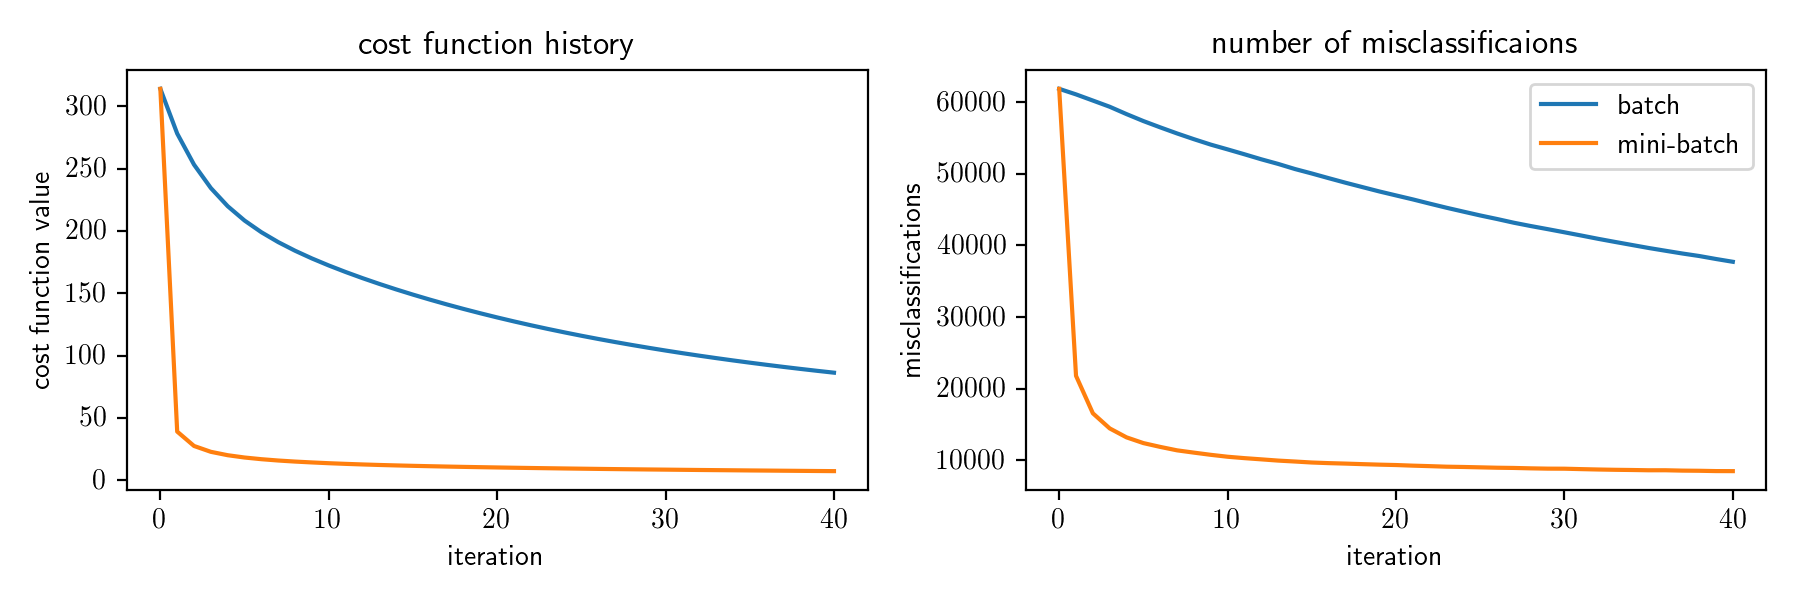

In [11]:
# This code cell will not be shown in the HTML version of this notebook
demo2 = mlplib.plotters.Visualizer()
demo2.compare_classification_histories(minibatch_multiclass_perceptron, x, y,
                                       batch_size=500, alpha=1e-4, max_its=40, version='unnonrmlized')

#### <span style="color:#a50e3e;">Example 2. </span>  Using momentum to speed up the minimization of linear two-class classification

The use of momentum is not limited to convex costs as non-convex functions can too have problematic long narrow valleys. In this example we compare the quality of solutions achieved by standard gradient descent and its momentum-adjusted version using the (non-convex) logistic Least Squares cost function on a simulated 1-d classification dataset. 
Both algorithms are initialized at the same point, and run for $25$ iterations with $\alpha = 1$. 

Moving the slider widget from left to right animates the optimization path taken by each algorithm as well as the corresponding fit to the data with (blue) and without (magenta) momentum. 


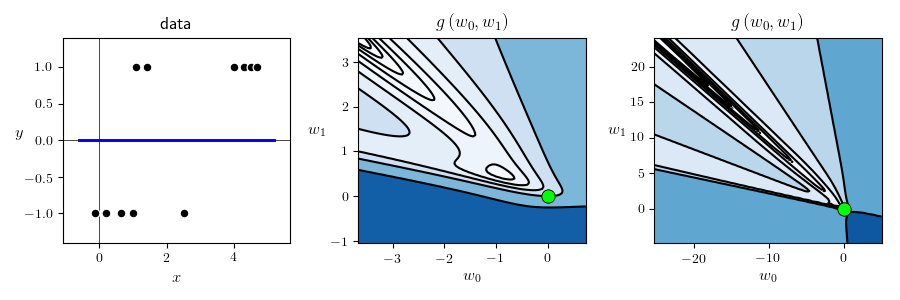
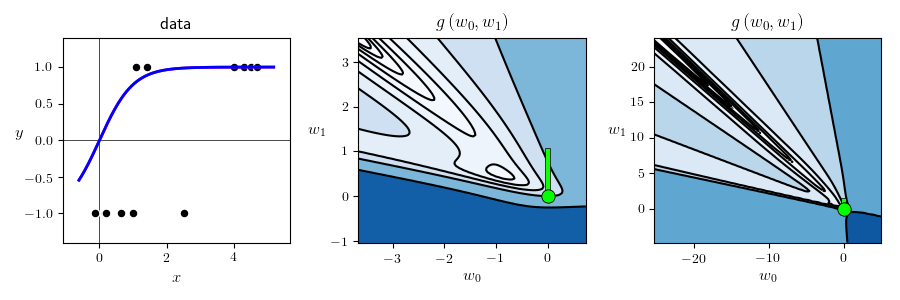
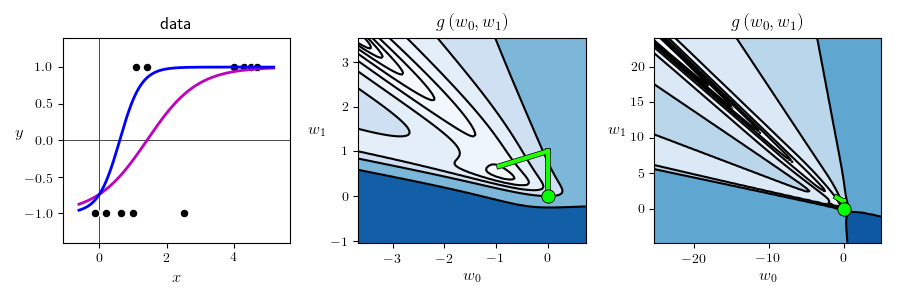
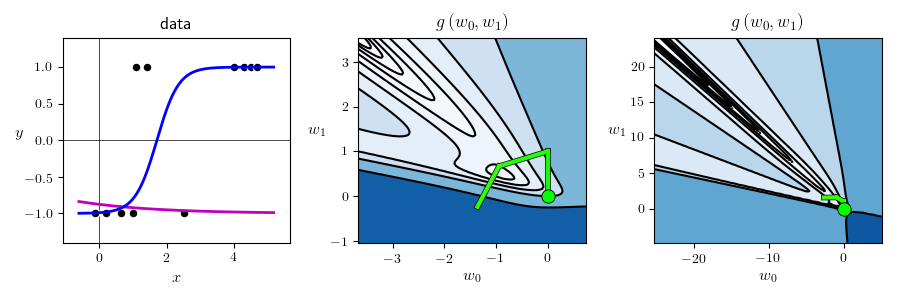
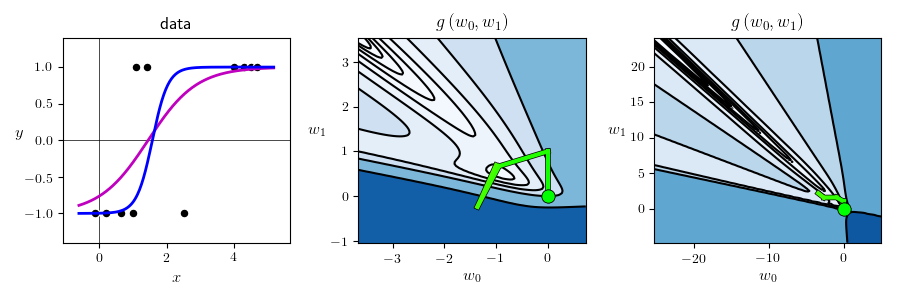
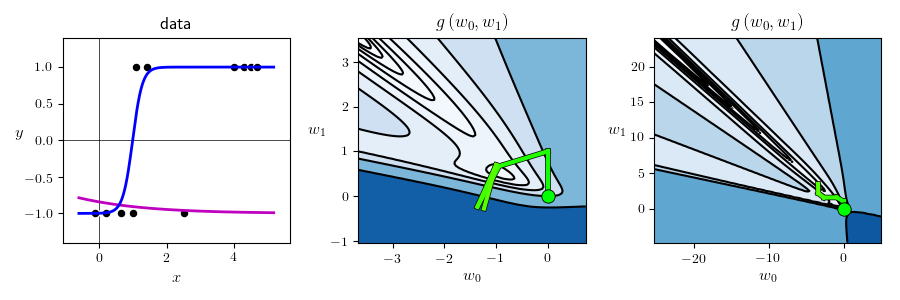
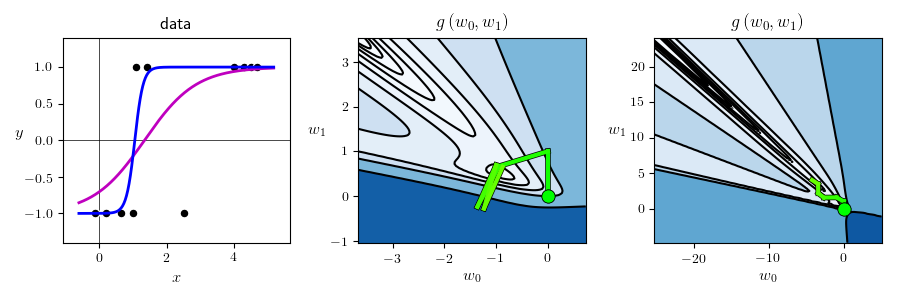
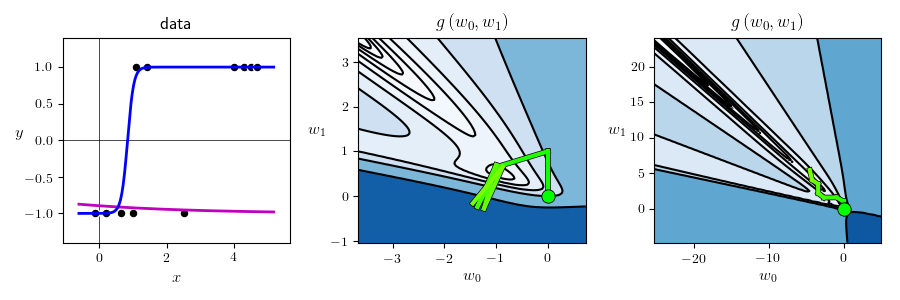
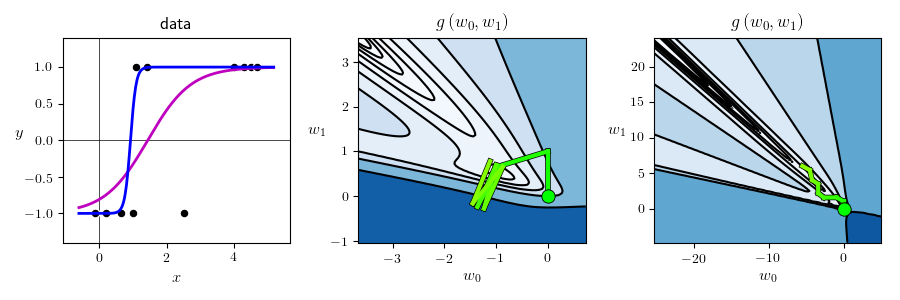
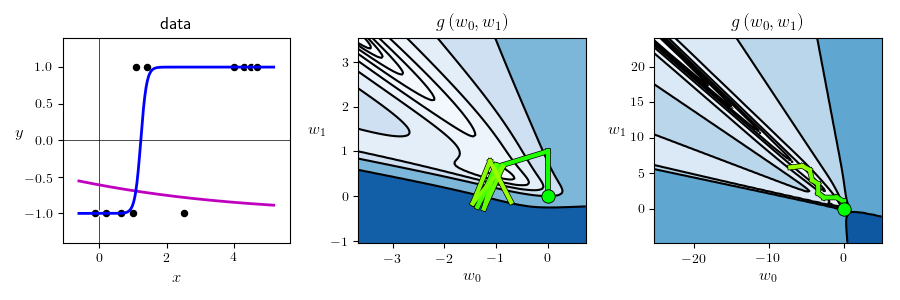
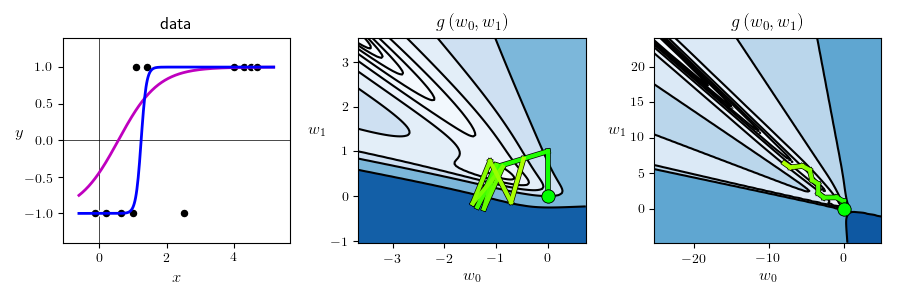
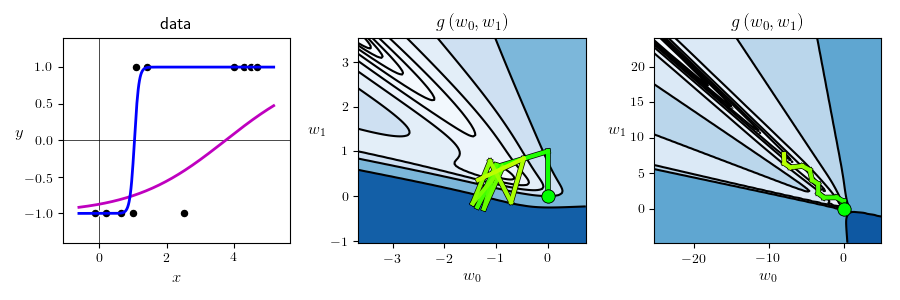
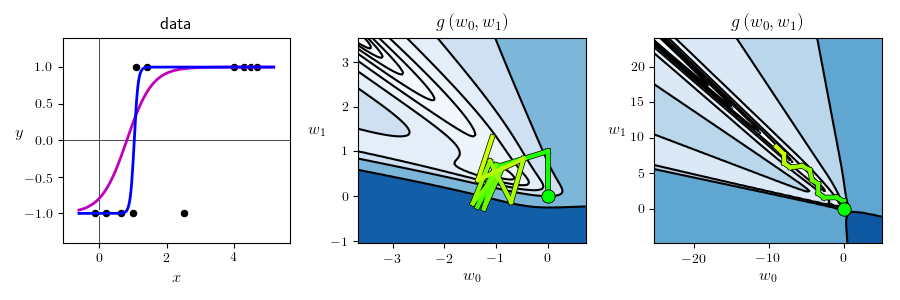
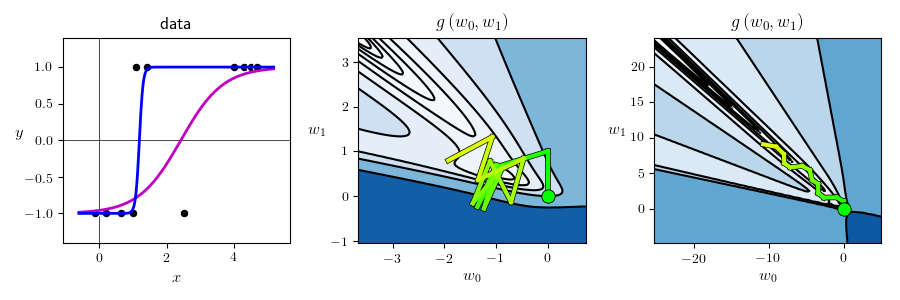
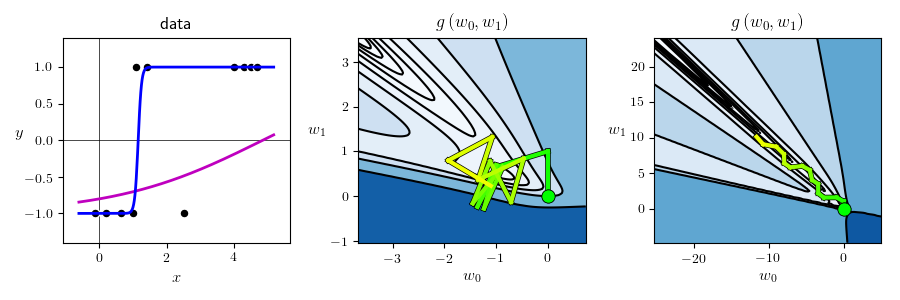
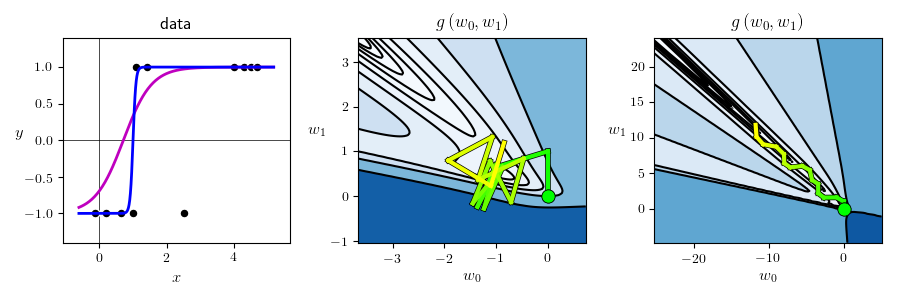
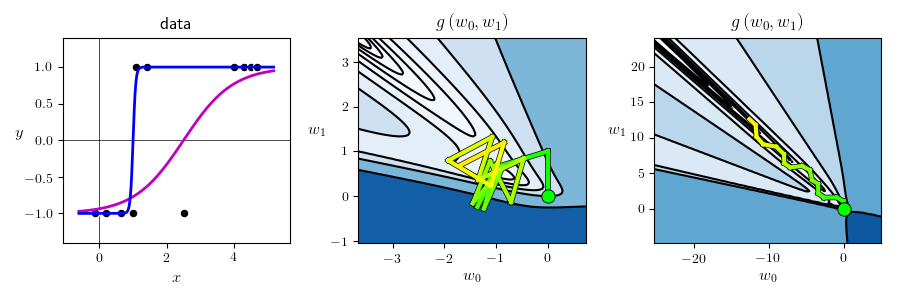
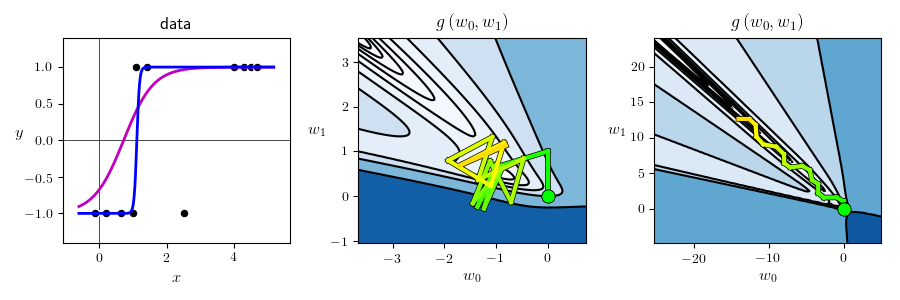
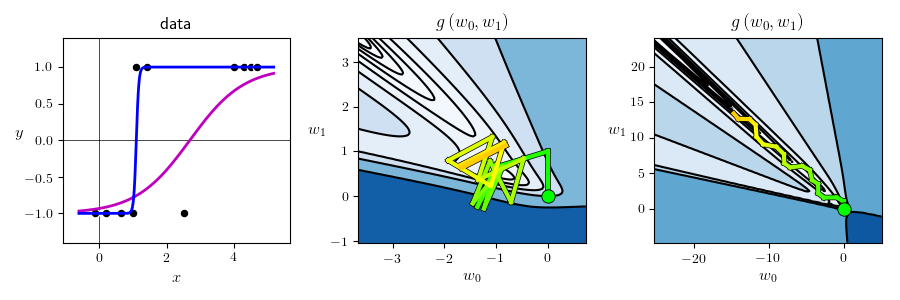
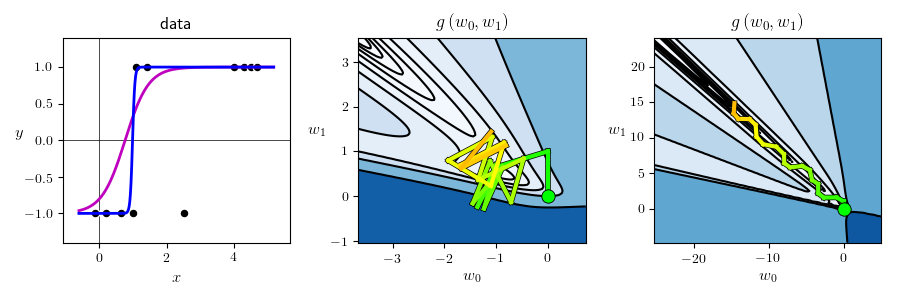
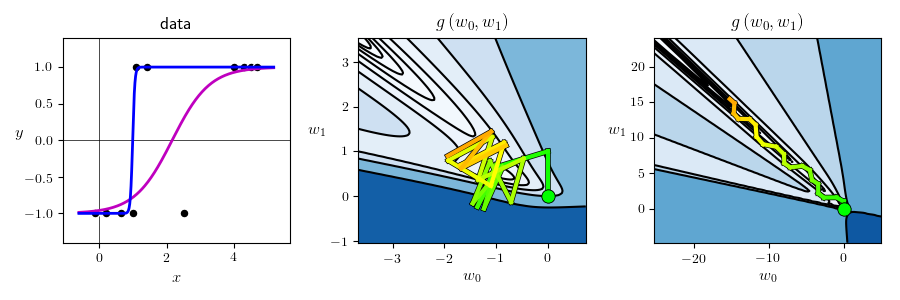
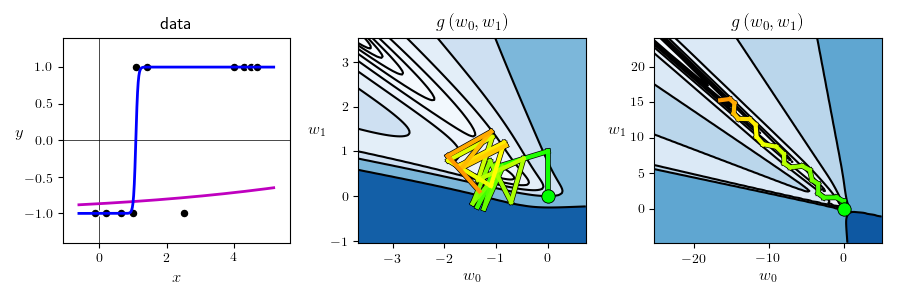
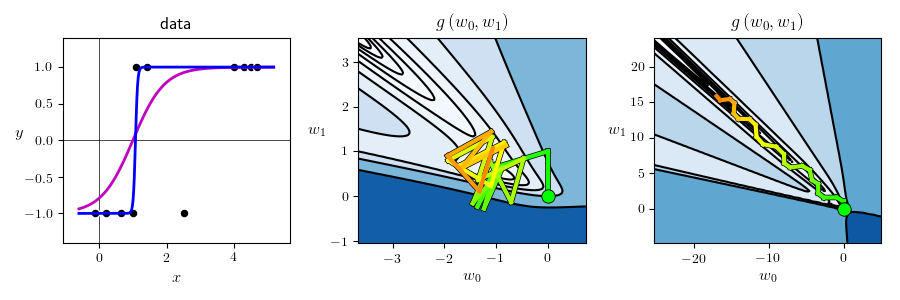
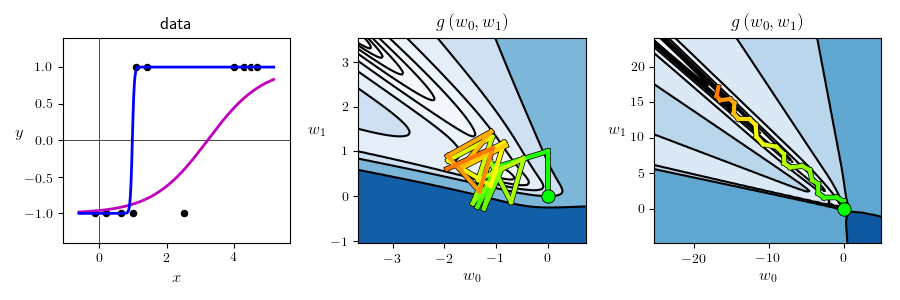
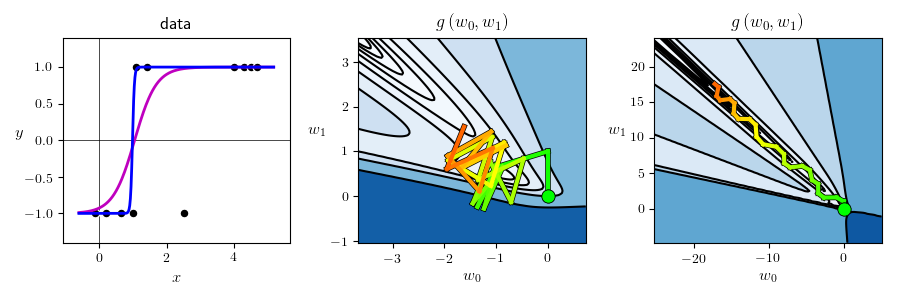
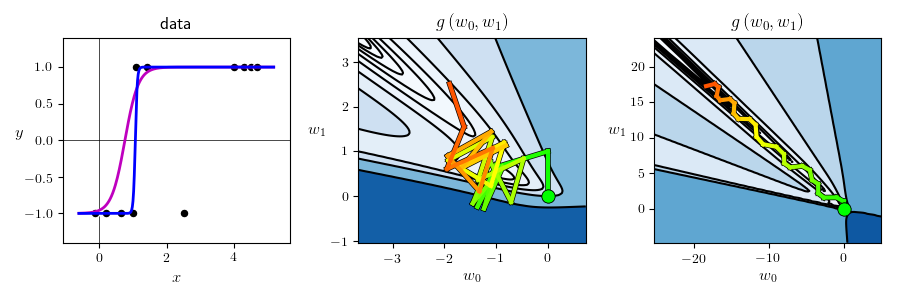
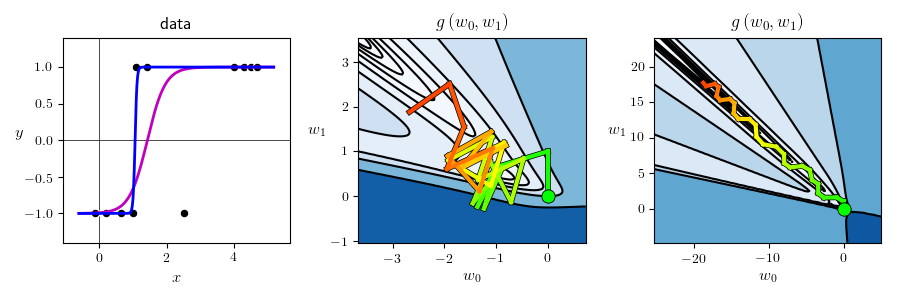
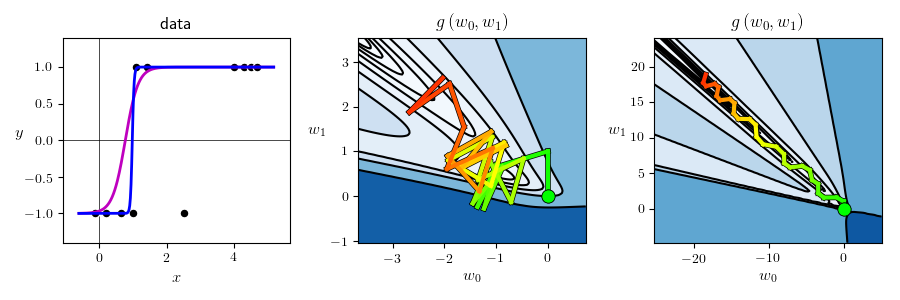
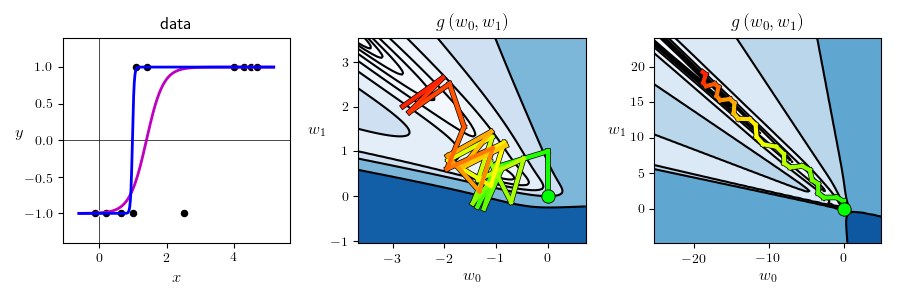
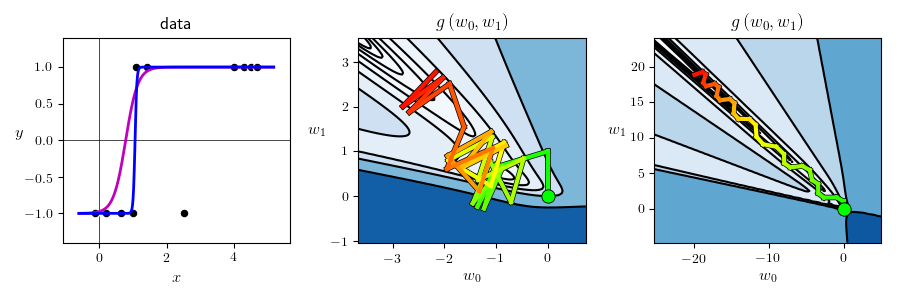
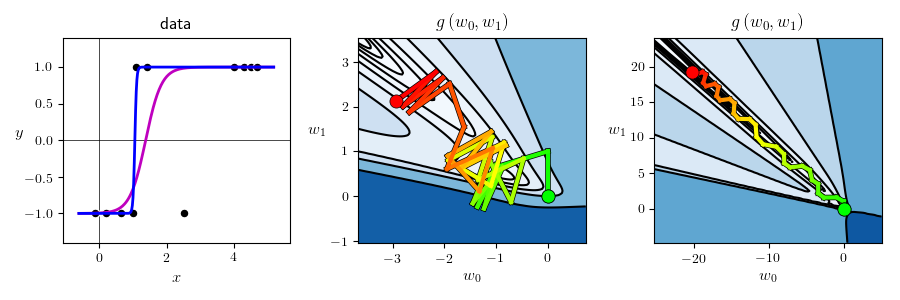

In [56]:
# This code cell will not be shown in the HTML version of this notebook
# tanh non-convex logistic least squares cost function
def tanh_least_squares(w):
    cost = 0
    for p in range(0,len(y)):
        x_p = x[p,:]
        y_p = y[p]
        cost +=(np.tanh(w[0] + w[1]*x_p) - y_p)**2
    return cost

# load in dataset
csvname = datapath + '2d_classification_data_v2.csv'
data = np.loadtxt(csvname, delimiter = ' ')

# define the input and output of our dataset
x = data[:,0]
x.shape = (len(x),1)
y = data[:,1]
y.shape = (len(y),1)

w_init[0] = 0
w_init[1] = 0
alpha = 1
max_its = 30
version = 'normalized'

# use momentum with beta = 0
beta = 0
weight_history_1 = gradient_descent(tanh_least_squares,w_init,alpha,max_its,beta,version)

# use momentum with beta = 0.9
beta = 0.9
weight_history_4 = gradient_descent(tanh_least_squares,w_init,alpha,max_its,beta,version)

# create instance of logisic regression demo and load in data, cost function, and descent history
demo3 = nonlib.classification_2d_demos_v2.Visualizer(data,tanh_least_squares)

# animate descent process
demo3.animate_runs(weight_history_1,weight_history_4,num_contours = 25)

#### <span style="color:#a50e3e;">Example 3. </span>  Using momentum for optimizing a multi-layer perceptron

In this Example we use gradient descent with and without momentum on a two-class classification dataset collected for the task of face detection, consisting of $P=10,000$ face and non-face images.

Once the data is loaded, we move on to initiate a supervised learning instance using our deep learning library, create a four-layer neural network basis consisting of $10$ units in each layer, and choose an activation function (here, ReLU), data normalization scheme (here, standard normalization) as well as the cost function (here, softmax).  

We now run gradient descent twice for $200$ iterations using the same initialization and steplength parameter, once without momentum ($\beta=0$) and once with momentum parameter set to $\beta=0.9$.   

<IPython.core.display.Javascript object>


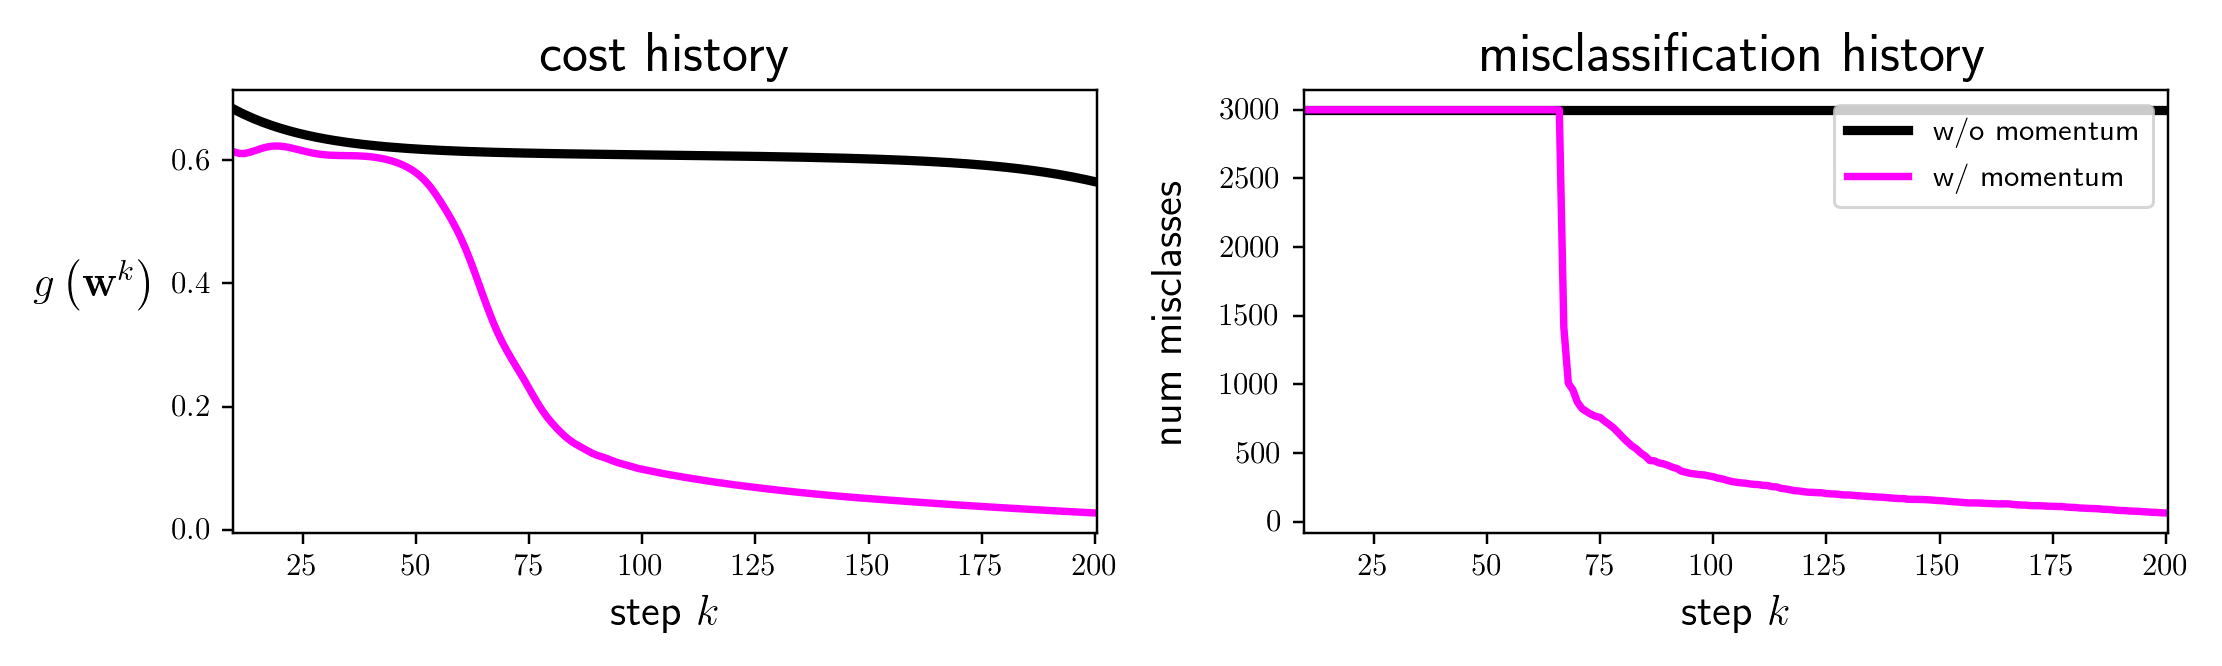

In [10]:
# This code cell will not be shown in the HTML version of this notebook
# import custom library
from mlrefined_libraries.deeplearning_library_v1 import superlearn_setup

# define path to datasets
datapath = '../../mlrefined_datasets/'

csvname = datapath + 'convnet_datasets/feat_face_data.csv'
data = np.loadtxt(csvname, delimiter = ',')
x = data[:,:-1].T
y = data[:,-1:].T

# initiate an instance
demo = superlearn_setup.Setup(x,y)

# choose a neural network architecture
demo.choose_features(name='multilayer_perceptron', layer_sizes=[784,10,10,10,10,1], activation='relu')

# choose a data normalization scheme
demo.choose_normalizer(name = 'standard')

# choose a cost function
demo.choose_cost(name = 'softmax')

# run gradient descent without momentum
demo.fit(max_its = 200, alpha_choice = 10**(-1), beta=0)

# run gradient descent with momentum
demo.fit(max_its = 200, alpha_choice = 10**(-1), beta=0.9)

# plot the results
demo.show_histories(start = 10, labels=['w/o momentum','w/ momentum'])

&copy; This material is not to be distributed, copied, or reused without written permission from the authors.